In [3]:
# ==========================================================
#  Cutoff–Policy Iteration with Quality (generator–adjoint)
#  - Mirrors the baseline (no-quality) algorithm step-by-step
#  - Adds quality layers and α depreciation links across layers
#  - HJB (implicit), KFE adjoint (implicit) + owner-share rescale
#  - HH–HH masses from ΔV ordering (per layer)
#  - HH–F acceptance via cutoffs δ1*(q), δ0*(q) with prices P0,P1
#  - Flipper 2×2 per layer, global F-split from totals
#  - Cutoff update: FOC residual roots (default) or greedy
# ==========================================================

from dataclasses import dataclass
import numpy as np

# ---------------------------
# Parameters and grids
# ---------------------------

@dataclass
class Params:
    r: float        # discount rate
    gamma: float    # type redraw rate
    rho: float      # HH–HH meeting rate
    lam: float      # HH–F meeting rate
    s: float        # owner share target: sum(H1)+F1 = s
    f: float        # total flipper mass F0+F1
    # quality
    q_min: float = 0.6
    q_max: float = 1.4
    alpha: float = 0.05    # quality depreciation rate k -> k-1 (reflect at bottom)
    # owner flow: u(δ,q) = δ * φ(q) - φ_H * q, with φ(q)=q^η
    eta: float = 1.0
    phi_H: float = 0.0

def make_grids(N_delta=121, N_q=41, q_min=0.6, q_max=1.4):
    delta = np.linspace(0.0, 1.0, N_delta)
    # trapezoid weights on δ normalized to 1
    w = np.ones(N_delta) * (1.0/(N_delta-1))
    w[0] *= 0.5; w[-1] *= 0.5
    w = w / w.sum()
    q = np.linspace(q_min, q_max, N_q)
    return delta, w, q

def varphi(q, eta=1.0):
    return np.power(q, eta)

# ---------------------------
# Helpers (flatten/stack)
# ---------------------------

def flat(M):      # Fortran order: δ fast, q slow
    return M.flatten(order='F')

def unflat(v, Nδ, Nq):
    return v.reshape((Nδ, Nq), order='F')

def stacked(v0, v1):
    return np.concatenate([v0, v1], axis=0)

def unstack(v):
    N2 = v.size // 2
    return v[:N2], v[N2:]

# ---------------------------
# Acceptance regions (HH–F) from cutoffs (per layer)
# ---------------------------

def acceptance_from_cutoffs(delta, d0, d1):
    """
    For each quality layer k:
      owners sell to F if δ <= d1[k]
      nonowners buy from F if δ >= d0[k]
    Returns two (Nδ, Nq) arrays of {0,1}.
    """
    Nδ, Nq = len(delta), len(d0)
    sellF = np.zeros((Nδ, Nq), dtype=float)
    buyF  = np.zeros((Nδ, Nq), dtype=float)
    for k in range(Nq):
        sellF[:, k] = (delta <= d1[k]).astype(float)
        buyF[:,  k] = (delta >= d0[k]).astype(float)
    return sellF, buyF

# ---------------------------
# Partner masses for HH–HH (ΔV ordering, per layer)
# ---------------------------

def partner_masses_layer(ΔV_k, H0tilde_k, H1tilde_k):
    """
    Given ΔV and masses at one layer k:
      M0_up[i]   = ∑_{j: ΔV_j >= ΔV_i} H0tilde[j]
      M1_down[i] = ∑_{j: ΔV_j <= ΔV_i} H1tilde[j]
      S0_up[i]   = ∑_{j: ΔV_j >= ΔV_i} H0tilde[j]*ΔV_j
      S1_down[i] = ∑_{j: ΔV_j <= ΔV_i} H1tilde[j]*ΔV_j
    """
    order = np.argsort(ΔV_k, kind='mergesort')  # ascending
    rank = np.empty_like(order); rank[order] = np.arange(order.size)

    H0o, H1o, DVo = H0tilde_k[order], H1tilde_k[order], ΔV_k[order]
    cH1   = np.cumsum(H1o);  cH1DV = np.cumsum(H1o*DVo)
    cH0   = np.cumsum(H0o);  cH0DV = np.cumsum(H0o*DVo)
    totH0, totH0DV = cH0[-1], cH0DV[-1]

    M1_down = cH1[rank]
    S1_down = cH1DV[rank]

    prefH0   = np.where(rank>0, cH0[rank-1], 0.0)
    prefH0DV = np.where(rank>0, cH0DV[rank-1], 0.0)
    M0_up = totH0   - prefH0
    S0_up = totH0DV - prefH0DV
    return M0_up, M1_down, S0_up, S1_down

def build_per_layer_M_arrays(ΔV, H0tilde, H1tilde):
    """Return M0_up, M1_down for all layers as arrays (Nδ,Nq)."""
    Nδ, Nq = ΔV.shape
    M0 = np.zeros_like(ΔV)
    M1 = np.zeros_like(ΔV)
    for k in range(Nq):
        M0_up, M1_down, _, _ = partner_masses_layer(ΔV[:, k], H0tilde[:, k], H1tilde[:, k])
        M0[:, k] = M0_up
        M1[:, k] = M1_down
    return M0, M1

# ---------------------------
# Hazards and generator A
# ---------------------------

def build_hazards(params, sellF, buyF, M0_up, M1_down, F0, F1):
    lam, rho = params.lam, params.rho
    aF10  = lam * F0 * sellF                 # owners -> nonowners via F
    aF01  = lam * F1 * buyF                  # nonowners -> owners via F
    aHH10 = rho * M0_up
    aHH01 = rho * M1_down
    return aF10, aF01, aHH10, aHH01

def assemble_A_and_phi(params, delta, w, q, sellF, buyF,
                       H0tilde, H1tilde, F0, F1, ΔV,
                       M0_full=None, M1_full=None):
    """
    Build generator A and price-flow φ across all layers.
    Uses current ΔV and (frozen) H masses to compute HH–HH price flows.
    Adds HH–F price flows with P0,P1 defined at the cutoffs per layer.
    """
    Nδ, Nq = len(delta), len(q)
    Nst = Nδ*Nq

    A  = np.zeros((2*Nst, 2*Nst))
    φ0 = np.zeros((Nδ, Nq))
    φ1 = np.zeros((Nδ, Nq))

    # per-layer pricing and cutoff indices
    P0 = np.zeros(Nq); P1 = np.zeros(Nq)
    i0_arr = np.zeros(Nq, dtype=int)  # index for δ0*(k)
    i1_arr = np.zeros(Nq, dtype=int)  # index for δ1*(k)

    # HH–HH price flows from ΔV ordering (per layer)
    for k in range(Nq):
        H0k, H1k = H0tilde[:, k], H1tilde[:, k]
        ΔVk = ΔV[:, k]

        M0_up, M1_down, S0_up, S1_down = partner_masses_layer(ΔVk, H0k, H1k)

        # cutoff indices from masks
        idx1 = np.max(np.where(sellF[:, k] > 0)[0]) if np.any(sellF[:, k]) else 0
        idx0 = np.min(np.where(buyF[:,  k] > 0)[0]) if np.any(buyF[:,  k]) else Nδ-1
        i1_arr[k], i0_arr[k] = idx1, idx0
        P0[k], P1[k] = float(ΔVk[idx1]), float(ΔVk[idx0])

        ρ = params.rho
        φ1[:, k] += 0.5 * ρ * (M0_up * ΔVk + S0_up)            # owners receive
        φ0[:, k] += -0.5 * ρ * (M1_down * ΔVk + S1_down)       # nonowners pay

    # hazards (use frozen M arrays if provided)
    if (M0_full is None) or (M1_full is None):
        M0_full, M1_full = build_per_layer_M_arrays(ΔV, H0tilde, H1tilde)
    aF10, aF01, aHH10, aHH01 = build_hazards(params, sellF, buyF, M0_full, M1_full, F0, F1)

    # add HH–F price flows
    for k in range(Nq):
        φ1[:, k] += aF10[:, k] * P0[k]
        φ0[:, k] += -aF01[:, k] * P1[k]

    # assemble generator A (rows sum to zero)
    γ, α = params.gamma, params.alpha
    onesδ = np.ones(Nδ)
    Γ = γ * np.outer(onesδ, w)  # redraw inflow inside each layer

    # diagonals within layer (outflows, no α yet)
    d0 = -(γ + aF01 + aHH01)   # V0 rows
    d1 = -(γ + aF10 + aHH10)   # V1 rows

    def add_block(block, h, k):
        r0 = (0 if h==0 else Nst) + k*Nδ
        c0 = r0
        A[r0:r0+Nδ, c0:c0+Nδ] += block

    for k in range(Nq):
        add_block(np.diag(d0[:, k]) + Γ, h=0, k=k)
        add_block(np.diag(d1[:, k]) + Γ, h=1, k=k)
        # cross status at same (i,k)
        A[k*Nδ:(k+1)*Nδ, Nst + k*Nδ : Nst + (k+1)*Nδ] += np.diag(aF01[:, k] + aHH01[:, k])  # into V0 from V1
        A[Nst + k*Nδ : Nst + (k+1)*Nδ, k*Nδ:(k+1)*Nδ] += np.diag(aF10[:, k] + aHH10[:, k])  # into V1 from V0

    # quality depreciation α: (i,k)->(i,k-1), reflect at bottom (k=0)
    if α > 0.0:
        for h in (0, 1):
            base = 0 if h==0 else Nst
            for k in range(Nq):
                rows = slice(base + k*Nδ, base + (k+1)*Nδ)
                if k > 0:
                    A[rows, rows] += -α * np.eye(Nδ)  # outflow from layer k
                    cols = slice(base + (k-1)*Nδ, base + k*Nδ)
                    A[rows, cols] += +α * np.eye(Nδ)  # inflow to k-1

    φ = stacked(flat(φ0), flat(φ1))
    aux = dict(P0=P0, P1=P1, i0=i0_arr, i1=i1_arr, M0=M0_full, M1=M1_full)
    return A, φ, aux

# ---------------------------
# HJB implicit (contraction) and KFE adjoint
# ---------------------------

def hjb_backward_euler(params, A, b, φ, V, dt=10.0, steps=100, tol=1e-10):
    r = params.r
    N2 = A.shape[0]
    K = (r + 1.0/dt) * np.eye(N2) - A
    rhs = b + φ
    for _ in range(steps):
        V_new = np.linalg.solve(K, rhs + V/dt)
        if np.max(np.abs(V_new - V)) < tol:
            return V_new
        V = V_new
    return V

def kfe_implicit_adjoint(A, H, dt=10.0, steps=100, tol=1e-10):
    K = np.eye(A.shape[0]) - dt * A.T
    for _ in range(steps):
        H_new = np.linalg.solve(K, H)
        if np.max(np.abs(H_new - H)) < tol:
            return H_new
        H = H_new
    return H

def renormalize_H(H):
    s = H.sum()
    return H if s<=0 else (H / s)

# ---------------------------
# Flippers (per layer) and split
# ---------------------------

def cdfs_and_pdfs_layerwise(H0tilde, H1tilde, w):
    H0_cdf = np.cumsum(H0tilde, axis=0)
    H1_cdf = np.cumsum(H1tilde, axis=0)
    eps = 1e-14
    h0 = H0tilde / np.clip(w[:, None], eps, None)
    h1 = H1tilde / np.clip(w[:, None], eps, None)
    return H0_cdf, H1_cdf, h0, h1

def flipper_per_layer_and_split(params, delta, H0_cdf, H1_cdf, i0, i1, P0, P1):
    lam, r = params.lam, params.r
    Nq = H0_cdf.shape[1]
    ΔW = np.zeros(Nq)
    q_b = np.zeros(Nq)
    q_s = np.zeros(Nq)
    for k in range(Nq):
        q_b[k] = lam * H1_cdf[i1[k], k]
        q_s[k] = lam * (H0_cdf[-1, k] - H0_cdf[i0[k], k])
        K = np.array([[r+q_b[k], -q_b[k]],
                      [-q_s[k],  r+q_s[k]]], float)
        rhs = np.array([-P0[k]*q_b[k], +P1[k]*q_s[k]], float)
        W0, W1 = np.linalg.solve(K, rhs)
        ΔW[k] = W1 - W0
    qb_tot, qs_tot = q_b.sum(), q_s.sum()
    if qb_tot + qs_tot > 0:
        F1 = params.f * qb_tot/(qb_tot + qs_tot)
    else:
        F1 = 0.5 * params.f
    F0 = params.f - F1
    return ΔW, F0, F1, q_b, q_s

# ---------------------------
# Cutoff updates: FOC and Greedy
# ---------------------------

def cutoff_focs_per_layer(delta, w, ΔV, H0tilde, H1tilde, ΔW):
    """
    Per layer k, find δ solving:
      R1(δ;k)=H1(δ;k) ΔV'(δ;k) - h1(δ;k)(ΔW(k)-ΔV(δ;k))=0
      R0(δ;k)=(H0(1;k)-H0(δ;k)) ΔV'(δ;k) - h0(δ;k)(ΔV(δ;k)-ΔW(k))=0
    by bracketed root on the grid (fallback: closest to zero).
    """
    Nδ, Nq = ΔV.shape
    H0_cdf = np.cumsum(H0tilde, axis=0)
    H1_cdf = np.cumsum(H1tilde, axis=0)
    eps = 1e-14
    h0 = H0tilde / np.clip(w[:, None], eps, None)
    h1 = H1tilde / np.clip(w[:, None], eps, None)
    d0_new = np.zeros(Nq); d1_new = np.zeros(Nq)
    for k in range(Nq):
        ΔVk = ΔV[:, k]
        DVp = np.gradient(ΔVk, delta)
        R1 = H1_cdf[:, k]*DVp - h1[:, k]*(ΔW[k]-ΔVk)
        R0 = (H0_cdf[-1, k] - H0_cdf[:, k])*DVp - h0[:, k]*(ΔVk-ΔW[k])

        def root_from(R):
            s = np.sign(R)
            idx = np.where(s[:-1]*s[1:]<=0)[0]
            if idx.size>0:
                j = int(idx[0])
                x0,x1 = delta[j], delta[j+1]
                y0,y1 = R[j], R[j+1]
                if abs(y1-y0)>1e-14:
                    x = x0 - y0*(x1-x0)/(y1-y0)
                else:
                    x = 0.5*(x0+x1)
                return float(np.clip(x, min(x0,x1), max(x0,x1)))
            # fallback: closest to zero on grid
            return float(delta[int(np.argmin(np.abs(R)))])

        d1_new[k] = root_from(R1)  # owners' sell cutoff
        d0_new[k] = root_from(R0)  # nonowners' buy cutoff
    return d0_new, d1_new

def greedy_cutoffs_per_layer(params, delta, ΔV, H0tilde, H1tilde, d0_prev, d1_prev, chi=0.4):
    lam = params.lam
    Nδ, Nq = ΔV.shape
    d0_new = np.zeros(Nq); d1_new = np.zeros(Nq)
    for k in range(Nq):
        H0_cdf = np.cumsum(H0tilde[:, k])
        H1_cdf = np.cumsum(H1tilde[:, k])
        q_b = lam * H1_cdf              # profit weight on sellers' side
        q_s = lam * (H0_cdf[-1] - H0_cdf)
        ΔW_guess = float(np.median(ΔV[:, k]))  # crude but robust
        profit_b = q_b * (ΔW_guess - ΔV[:, k])
        profit_s = q_s * (ΔV[:, k] - ΔW_guess)
        i1 = int(np.argmax(profit_b))
        i0 = int(np.argmax(profit_s))
        d1_new[k] = delta[i1]
        d0_new[k] = delta[i0]
    # damp and enforce order outside
    d0 = (1-chi)*d0_prev + chi*d0_new
    d1 = (1-chi)*d1_prev + chi*d1_new
    mid = 0.5*(d0+d1)
    swap = d1 > d0
    if np.any(swap):
        d0[swap] = np.maximum(mid[swap], d0[swap])
        d1[swap] = np.minimum(mid[swap], d1[swap])
    return d0, d1

# ---------------------------
# Main solver (cutoff policy iteration, with quality)
# ---------------------------

def solve_model_quality(params,
                        N_delta=121, N_q=41,
                        d0_init=0.50, d1_init=0.15,
                        update_method="foc", chi=0.35,
                        max_outer=300, tol_cutoff=1e-4,
                        hjb_dt=12.0, hjb_steps=200, hjb_tol=1e-10,
                        kfe_dt=12.0, kfe_steps=200, kfe_tol=1e-10,
                        verbose=True, seed=0):
    rng = np.random.default_rng(seed)

    delta, w, q = make_grids(N_delta, N_q, params.q_min, params.q_max)
    Nδ, Nq = len(delta), len(q)
    Nst = Nδ*Nq

    # initial masses (uniform across layers, split half owners)
    H_layer_mass = 1.0 / Nq
    H0tilde = np.tile((0.5 * w * H_layer_mass), (Nq,1)).T
    H1tilde = np.tile((0.5 * w * H_layer_mass), (Nq,1)).T

    # initial values
    V0 = np.zeros((Nδ, Nq))
    V1 = (delta[:, None]*varphi(q, params.eta)[None, :] - params.phi_H*q[None, :]) / (params.r + params.gamma + 1e-9)
    V = stacked(flat(V0), flat(V1))
    ΔV = V1 - V0

    # initial cutoffs (per layer) and flipper split
    d0 = np.full(Nq, float(d0_init))
    d1 = np.full(Nq, float(min(d1_init, d0_init)))
    F0, F1 = 0.5*params.f, 0.5*params.f

    history = []

    for it in range(max_outer):

        # 1) HH–F acceptance masks
        sellF, buyF = acceptance_from_cutoffs(delta, d0, d1)

        # 2) partner masses (freeze for this outer iteration)
        M0_full, M1_full = build_per_layer_M_arrays(ΔV, H0tilde, H1tilde)

        # 3) hazards and generator A + price flows φ (with current F0,F1)
        b = np.zeros(2*Nst)
        b[Nst:] = flat(delta[:, None]*varphi(q, params.eta)[None, :] - params.phi_H*q[None, :])

        A, φ, aux = assemble_A_and_phi(params, delta, w, q, sellF, buyF,
                                       H0tilde, H1tilde, F0, F1, ΔV,
                                       M0_full, M1_full)

        # 4) HJB implicit update
        V_old = V.copy()
        V = hjb_backward_euler(params, A, b, φ, V, dt=hjb_dt, steps=hjb_steps, tol=hjb_tol)
        V0_vec, V1_vec = unstack(V)
        V0 = unflat(V0_vec, Nδ, Nq); V1 = unflat(V1_vec, Nδ, Nq)
        ΔV = V1 - V0
        bell = float(np.max(np.abs(V - V_old)))

        # refresh P0,P1 from updated ΔV (indexes from aux)
        P0, P1, i0, i1 = aux['P0'].copy(), aux['P1'].copy(), aux['i0'], aux['i1']
        for k in range(Nq):
            P0[k] = float(ΔV[i1[k], k])
            P1[k] = float(ΔV[i0[k], k])

        # 5) flippers per layer -> ΔW_k and new F split (global)
        H0_cdf, H1_cdf, h0, h1 = cdfs_and_pdfs_layerwise(H0tilde, H1tilde, w)
        ΔW_k, F0, F1, qb, qs = flipper_per_layer_and_split(params, delta, H0_cdf, H1_cdf, i0, i1, P0, P1)

        # 6) KFE adjoint implicit steps (with current A), normalize, owner-share rescale
        H_vec_old = stacked(flat(H0tilde), flat(H1tilde))
        H_vec = kfe_implicit_adjoint(A, H_vec_old, dt=kfe_dt, steps=kfe_steps, tol=kfe_tol)
        H_vec = renormalize_H(H_vec)
        H0tilde = unflat(H_vec[:Nst], Nδ, Nq)
        H1tilde = unflat(H_vec[Nst:], Nδ, Nq)
        # owner-share target: sum(H1)+F1 = s  -> rescale H1 proportionally
        target_H1 = max(1e-12, params.s - F1)
        cur_H1 = float(H1tilde.sum())
        cur_H0 = float(H0tilde.sum())
        if cur_H1 > 0:
            H1tilde *= target_H1 / cur_H1
        if cur_H0 > 0:
            H0tilde *= (1.0 - target_H1) / cur_H0

        # 7) cutoff update (per layer)
        if update_method.lower() == "foc":
            d0_new, d1_new = cutoff_focs_per_layer(delta, w, ΔV, H0tilde, H1tilde, ΔW_k)
            d0 = (1.0 - chi) * d0 + chi * d0_new
            d1 = (1.0 - chi) * d1 + chi * d1_new
        else:
            d0, d1 = greedy_cutoffs_per_layer(params, delta, ΔV, H0tilde, H1tilde, d0, d1, chi=chi)

        # enforce order per layer
        mid = 0.5*(d0 + d1)
        swap = d1 > d0
        if np.any(swap):
            d0[swap] = np.maximum(mid[swap], d0[swap])
            d1[swap] = np.minimum(mid[swap], d1[swap])

        # diagnostics
        cutdiff = float(max(np.max(np.abs(d0_new - d0)) if update_method=="foc" else 0.0,
                            np.max(np.abs(d1_new - d1)) if update_method=="foc" else 0.0))
        if verbose:
            print(f"[it {it:03d}] |Bell|={bell:.2e}  |Δδ|max={cutdiff:.2e}  F1={F1:.5f}  "
                  f"d0̄={np.mean(d0):.3f} d1̄={np.mean(d1):.3f}")

        history.append((bell, cutdiff, float(F1)))

        # stopping rule: same spirit as baseline
        if (bell < 1e-10) and (cutdiff < tol_cutoff):
            if verbose:
                print(f"Converged in {it} iterations.")
            break

    return dict(
        delta=delta, w=w, q=q,
        V0=V0, V1=V1, ΔV=ΔV,
        H0tilde=H0tilde, H1tilde=H1tilde,
        d0_star=d0, d1_star=d1,
        P0=P0, P1=P1,
        F0=F0, F1=F1,
        A=A, b=b, history=history
    )

# ---------------------------
# Example run
# ---------------------------

if __name__ == "__main__":
    # pick numbers close to your baseline and expand in q
    params = Params(
        r=0.0361577940, gamma=0.0867540457, rho=1.0, lam=1.5,
        s=0.70, f=0.02, q_min=0.8, q_max=1.0, alpha=0.08,
        eta=0.9, phi_H=0.6
    )

    out = solve_model_quality(
        params,
        N_delta=51, N_q=11,
        d0_init=0.48, d1_init=0.11,
        update_method="foc", chi=0.03,
        max_outer=600, tol_cutoff=1e-4,
        hjb_dt=12.0, hjb_steps=100, hjb_tol=1e-4,
        kfe_dt=12.0, kfe_steps=100, kfe_tol=1e-4,
        verbose=True, seed=0
    )

    print("\n--- Final summary ---")
    print("mean δ0*(q):", float(np.mean(out['d0_star'])))
    print("mean δ1*(q):", float(np.mean(out['d1_star'])))
    print("F split     :", float(out['F0']), float(out['F1']))
    print("Mass check  :", float((out['H0tilde']+out['H1tilde']).sum()))


[it 000] |Bell|=9.58e-01  |Δδ|max=2.76e-01  F1=0.00355  d0̄=0.488 d1̄=0.116
[it 001] |Bell|=2.24e+00  |Δδ|max=4.07e-01  F1=0.00594  d0̄=0.500 d1̄=0.124
[it 002] |Bell|=1.39e+00  |Δδ|max=4.09e-01  F1=0.00661  d0̄=0.512 d1̄=0.132
[it 003] |Bell|=2.88e-01  |Δδ|max=4.15e-01  F1=0.00730  d0̄=0.523 d1̄=0.141
[it 004] |Bell|=2.27e-01  |Δδ|max=4.20e-01  F1=0.00815  d0̄=0.535 d1̄=0.149
[it 005] |Bell|=2.04e-01  |Δδ|max=4.25e-01  F1=0.00827  d0̄=0.546 d1̄=0.157
[it 006] |Bell|=1.78e-01  |Δδ|max=4.29e-01  F1=0.00931  d0̄=0.557 d1̄=0.166
[it 007] |Bell|=1.56e-01  |Δδ|max=4.22e-01  F1=0.00972  d0̄=0.568 d1̄=0.173
[it 008] |Bell|=1.38e-01  |Δδ|max=4.09e-01  F1=0.00972  d0̄=0.579 d1̄=0.181
[it 009] |Bell|=1.22e-01  |Δδ|max=3.97e-01  F1=0.01065  d0̄=0.589 d1̄=0.189
[it 010] |Bell|=1.07e-01  |Δδ|max=3.85e-01  F1=0.01105  d0̄=0.600 d1̄=0.196
[it 011] |Bell|=9.59e-02  |Δδ|max=3.73e-01  F1=0.01105  d0̄=0.610 d1̄=0.204
[it 012] |Bell|=8.54e-02  |Δδ|max=3.62e-01  F1=0.01188  d0̄=0.619 d1̄=0.211
[it 013] |Be

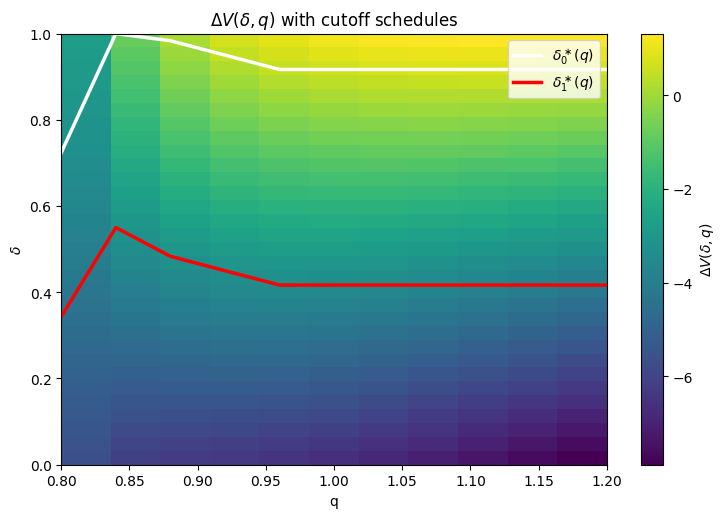

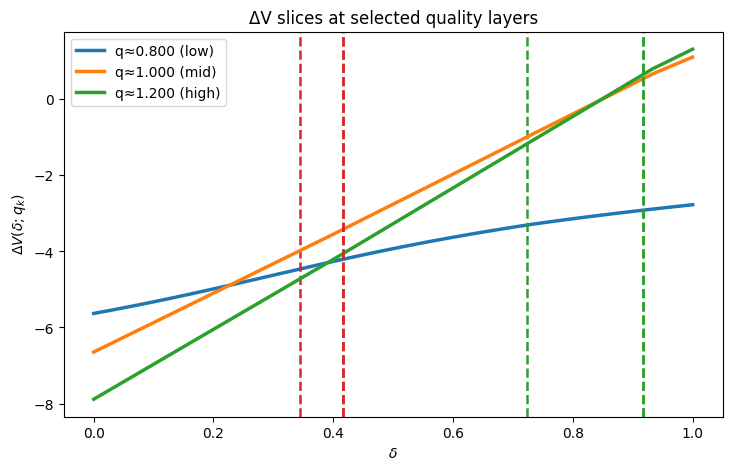

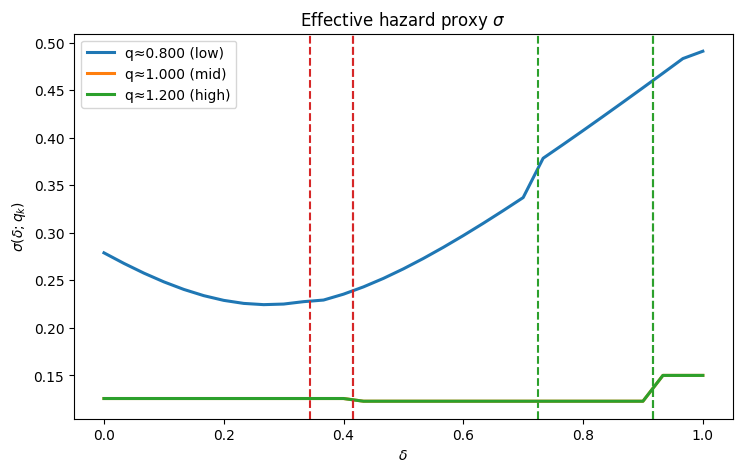

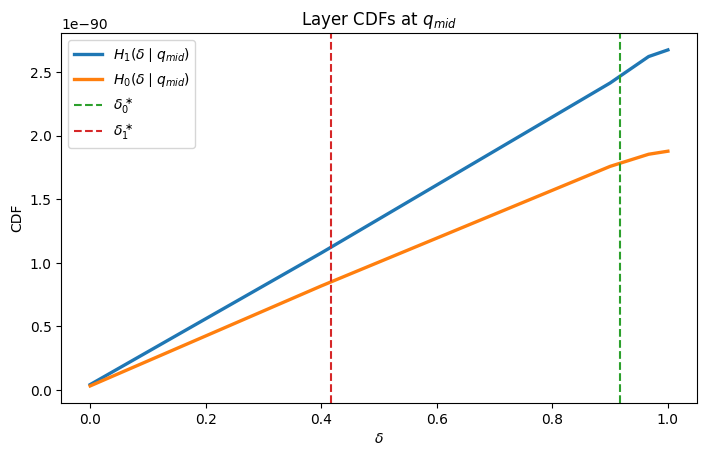

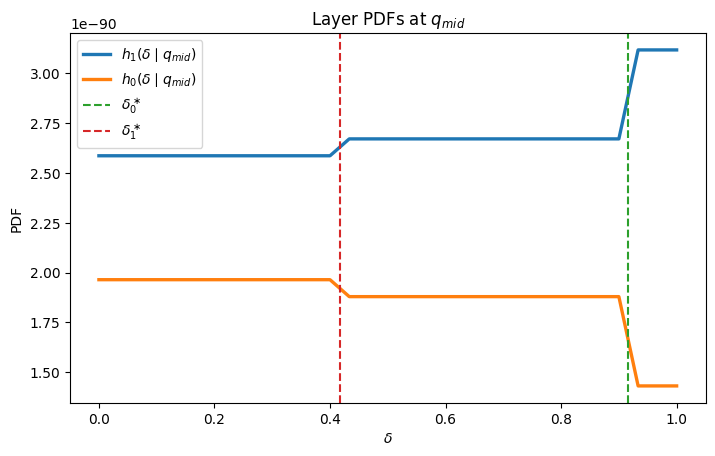

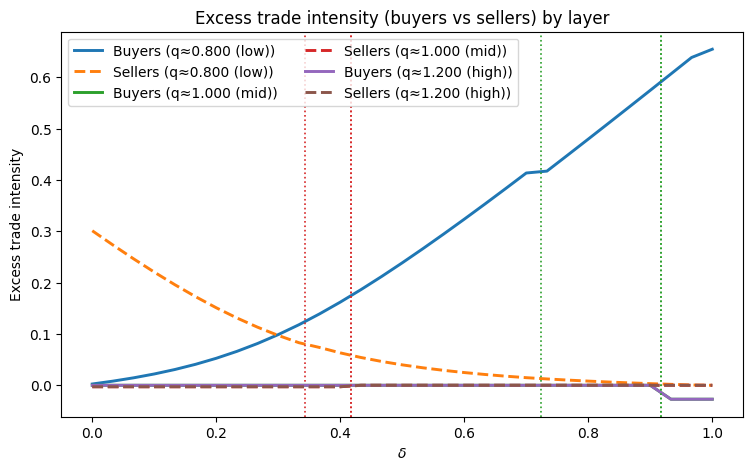

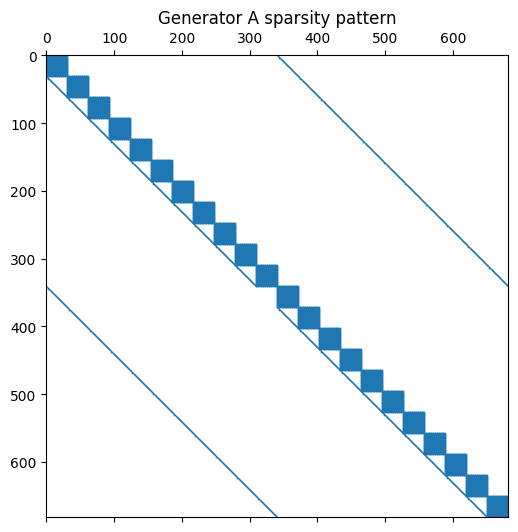

In [2]:
# ============================================================
# Plotting for the CT generator–adjoint solver WITH QUALITY q
# ============================================================
import os
import numpy as np
import matplotlib.pyplot as plt

# ---------- helpers ----------
def _cdf_from_mass_layerwise(Htilde):
    return np.cumsum(Htilde, axis=0)

def _pdf_from_mass_layerwise(Htilde, wδ):
    eps = 1e-14
    return Htilde / np.clip(wδ[:, None], eps, None)

def _sigma_curve_layer(delta, H0_cdf_k, H1_cdf_k, F0, F1, params, d0_k, d1_k):
    r, gamma, lam, rho = params.r, params.gamma, params.lam, params.rho
    H0_1 = float(H0_cdf_k[-1])
    ind_right = (delta > d0_k).astype(float)
    ind_left  = (delta < d1_k).astype(float)
    return (r + gamma
            + lam * F1 * ind_right
            + lam * F0 * ind_left
            + 0.5 * rho * (H0_1 - H0_cdf_k)
            + 0.5 * rho * H1_cdf_k)

def _maybe_save(path):
    if path:
        os.makedirs(os.path.dirname(path), exist_ok=True)
        plt.savefig(path, bbox_inches='tight')

def _pick_layers(q, how=('low','mid','high')):
    Nq = len(q)
    if isinstance(how, (list, tuple)):
        if all(isinstance(x, str) for x in how):
            idxs, labels = [], []
            for tag in how:
                if tag.lower() == 'low':
                    idxs.append(0); labels.append(f"q≈{q[0]:.3f} (low)")
                elif tag.lower() == 'mid':
                    m = Nq//2; idxs.append(m); labels.append(f"q≈{q[m]:.3f} (mid)")
                elif tag.lower() == 'high':
                    idxs.append(Nq-1); labels.append(f"q≈{q[-1]:.3f} (high)")
            return idxs, labels
        else:
            idxs = [int(np.clip(i, 0, Nq-1)) for i in how]
            labels = [f"q≈{q[i]:.3f}" for i in idxs]
            return idxs, labels
    return [0, Nq//2, len(q)-1], [f"q≈{q[0]:.3f} (low)", f"q≈{q[Nq//2]:.3f} (mid)", f"q≈{q[-1]:.3f} (high)"]

# ---------- main plotting ----------
def plot_all_quality(out, params, selected_layers=('low','mid','high'),
                     save_dir=None, heatmap_cmap='viridis'):
    delta = out['delta']
    # FIX: accept either 'wδ' or 'w' from the solver output
    wδ    = out['wδ'] if 'wδ' in out else out['w']
    q     = out['q']
    ΔV    = out['ΔV']
    H0̃    = out['H0tilde']
    H1̃    = out['H1tilde']
    d0    = out['d0_star']
    d1    = out['d1_star']
    F0    = out['F0']
    F1    = out['F1']

    H0t = H0̃; H1t = H1̃
    Nδ, Nq = ΔV.shape

    # CDF/PDF per layer
    H0_cdf_mat = _cdf_from_mass_layerwise(H0t)
    H1_cdf_mat = _cdf_from_mass_layerwise(H1t)
    h0_pdf_mat = _pdf_from_mass_layerwise(H0t, wδ)
    h1_pdf_mat = _pdf_from_mass_layerwise(H1t, wδ)

    # === A) Heatmap ΔV(δ,q) + cutoffs overlay ===
    plt.figure(figsize=(8.8, 5.6))
    extent = [q[0], q[-1], delta[0], delta[-1]]
    plt.imshow(ΔV, aspect='auto', origin='lower', extent=extent, cmap=heatmap_cmap)
    cbar = plt.colorbar(); cbar.set_label(r'$\Delta V(\delta,q)$')
    plt.plot(q, d0, lw=2.5, color='white', label=r'$\delta_0^\ast(q)$')
    plt.plot(q, d1, lw=2.5, color='red',   label=r'$\delta_1^\ast(q)$')
    plt.xlabel('q'); plt.ylabel(r'$\delta$')
    plt.title(r'$\Delta V(\delta,q)$ with cutoff schedules')
    plt.legend(loc='upper right', frameon=True)
    if save_dir: _maybe_save(os.path.join(save_dir, 'Q_f1_heatmap_DeltaV_cutoffs.pdf'))
    plt.show()

    # pick layers
    layer_idx, layer_labels = _pick_layers(q, selected_layers)

    # === B) ΔV(δ; q_k) lines ===
    plt.figure(figsize=(8.5, 5.0))
    for idx, lab in zip(layer_idx, layer_labels):
        plt.plot(delta, ΔV[:, idx], lw=2.5, label=lab)
        plt.axvline(d0[idx], color='tab:green', ls='--', lw=1.8)
        plt.axvline(d1[idx], color='tab:red',   ls='--', lw=1.8)
    plt.xlabel(r'$\delta$'); plt.ylabel(r'$\Delta V(\delta; q_k)$')
    plt.title(r'ΔV slices at selected quality layers')
    plt.legend()
    if save_dir: _maybe_save(os.path.join(save_dir, 'Q_f2_DeltaV_layer_slices.pdf'))
    plt.show()

    # === C) σ_k(δ) for selected layers ===
    plt.figure(figsize=(8.5, 5.0))
    for idx, lab in zip(layer_idx, layer_labels):
        sigma_k = _sigma_curve_layer(delta, H0_cdf_mat[:, idx], H1_cdf_mat[:, idx],
                                     F0, F1, params, d0[idx], d1[idx])
        plt.plot(delta, sigma_k, lw=2.2, label=lab)
        plt.axvline(d0[idx], color='tab:green', ls='--', lw=1.5)
        plt.axvline(d1[idx], color='tab:red',   ls='--', lw=1.5)
    plt.xlabel(r'$\delta$'); plt.ylabel(r'$\sigma(\delta; q_k)$')
    plt.title(r'Effective hazard proxy $\sigma$')
    plt.legend()
    if save_dir: _maybe_save(os.path.join(save_dir, 'Q_f3_sigma_layers.pdf'))
    plt.show()

    # === D) CDFs at q_mid ===
    mid = Nq // 2
    plt.figure(figsize=(8.2, 4.8))
    plt.plot(delta, H1_cdf_mat[:, mid], lw=2.4, label=r'$H_1(\delta\mid q_{mid})$')
    plt.plot(delta, H0_cdf_mat[:, mid], lw=2.4, label=r'$H_0(\delta\mid q_{mid})$')
    plt.axvline(d0[mid], color='tab:green', ls='--', lw=1.5, label=r'$\delta_0^\ast$')
    plt.axvline(d1[mid], color='tab:red',   ls='--', lw=1.5, label=r'$\delta_1^\ast$')
    plt.xlabel(r'$\delta$'); plt.ylabel(r'CDF')
    plt.title(r'Layer CDFs at $q_{mid}$')
    plt.legend()
    if save_dir: _maybe_save(os.path.join(save_dir, 'Q_f4_CDF_mid.pdf'))
    plt.show()

    # === E) PDFs at q_mid ===
    plt.figure(figsize=(8.2, 4.8))
    plt.plot(delta, h1_pdf_mat[:, mid], lw=2.4, label=r'$h_1(\delta\mid q_{mid})$')
    plt.plot(delta, h0_pdf_mat[:, mid], lw=2.4, label=r'$h_0(\delta\mid q_{mid})$')
    plt.axvline(d0[mid], color='tab:green', ls='--', lw=1.5, label=r'$\delta_0^\ast$')
    plt.axvline(d1[mid], color='tab:red',   ls='--', lw=1.5, label=r'$\delta_1^\ast$')
    plt.xlabel(r'$\delta$'); plt.ylabel(r'PDF')
    plt.title(r'Layer PDFs at $q_{mid}$')
    plt.legend()
    if save_dir: _maybe_save(os.path.join(save_dir, 'Q_f5_PDF_mid.pdf'))
    plt.show()

    # === F) Excess-trade intensity for selected layers ===
    plt.figure(figsize=(8.8, 5.0))
    for idx, lab in zip(layer_idx, layer_labels):
        buyers  = params.rho * H1_cdf_mat[:, idx] - params.lam * F1 * (delta > d0[idx]).astype(float)
        sellers = params.rho * (H0_cdf_mat[-1, idx] - H0_cdf_mat[:, idx]) - params.lam * F0 * (delta < d1[idx]).astype(float)
        plt.plot(delta, buyers,  lw=2.1, label=f'Buyers ({lab})')
        plt.plot(delta, sellers, lw=2.1, ls='--', label=f'Sellers ({lab})')
        plt.axvline(d0[idx], color='tab:green', ls=':', lw=1.2)
        plt.axvline(d1[idx], color='tab:red',   ls=':', lw=1.2)
    plt.xlabel(r'$\delta$'); plt.ylabel('Excess trade intensity')
    plt.title('Excess trade intensity (buyers vs sellers) by layer')
    plt.legend(ncol=2)
    if save_dir: _maybe_save(os.path.join(save_dir, 'Q_f6_excess_trade_layers.pdf'))
    plt.show()

    # Optional: sparsity structure of A (only if present)
    if 'A' in out and out['A'] is not None:
        plt.figure(figsize=(6.2, 6.0))
        plt.spy(out['A'], markersize=0.3)
        plt.title('Generator A sparsity pattern')
        if save_dir: _maybe_save(os.path.join(save_dir, 'Q_f7_A_spy.pdf'))
        plt.show()

# ---- example call
plot_all_quality(out, params, selected_layers=('low','mid','high'),
                 save_dir=None, heatmap_cmap='viridis')


In [ ]:
# ===============================================
# Grid runner: sweep params, solve, extract, log
# ===============================================
import os, json, itertools, time
import numpy as np
import pandas as pd

def _fmt(x, nd=3):
    return f"{x:.{nd}f}".replace('.', 'p')  # tag-friendly

def _tag_from_params(p):
    return ("r"+_fmt(p.r,3) + "_g"+_fmt(p.gamma,3) +
            "_rho"+_fmt(p.rho,2) + "_lam"+_fmt(p.lam,2) +
            "_s"+_fmt(p.s,2) + "_f"+_fmt(p.f,3) +
            "_eta"+_fmt(p.eta,2) + "_phiH"+_fmt(p.phi_H,2) +
            "_a"+_fmt(p.alpha,2))

def run_grid_and_extract(base_params: Params,
                         vary_dict: dict,
                         save_dir="./grid_outputs",
                         numerics=None,
                         N_delta=31, N_q=11,
                         update_method="foc", chi=0.05,
                         max_outer=600, tol_cutoff=1e-4,
                         hjb_dt=12.0, hjb_steps=100, hjb_tol=1e-4,
                         kfe_dt=12.0, kfe_steps=100, kfe_tol=1e-4,
                         seed=0):
    """
    vary_dict: {"rho":[...], "lam":[...], "eta":[...], "phi_H":[...], ...}
    Any field in Params can be listed here. Others are taken from base_params.
    """
    os.makedirs(save_dir, exist_ok=True)
    keys = list(vary_dict.keys())
    values_list = [vary_dict[k] for k in keys]
    combos = list(itertools.product(*values_list))

    master_rows = []
    t0 = time.time()
    for idx, combo in enumerate(combos, start=1):
        # build params for this run
        kwargs = {k: getattr(base_params, k) for k in base_params.__dataclass_fields__.keys()}
        for k, v in zip(keys, combo):
            kwargs[k] = v
        p = Params(**kwargs)

        # solve
        try:
            out = solve_model_quality(
                p,
                N_delta=N_delta, N_q=N_q,
                d0_init=0.48, d1_init=0.11,
                update_method=update_method, chi=chi,
                max_outer=max_outer, tol_cutoff=tol_cutoff,
                hjb_dt=hjb_dt, hjb_steps=hjb_steps, hjb_tol=hjb_tol,
                kfe_dt=kfe_dt, kfe_steps=kfe_steps, kfe_tol=kfe_tol,
                verbose=True, seed=seed
            )
            tag = _tag_from_params(p)
            subdir = os.path.join(save_dir, tag)
            os.makedirs(subdir, exist_ok=True)
            # extract + save
            paths = extract_summary_by_q(out, p, save_dir=subdir, tag=tag)
            # quick run-level summary
            d0, d1 = out["d0_star"], out["d1_star"]
            P0, P1 = out["P0"], out["P1"]
            row = {
                "tag": tag,
                "r": p.r, "gamma": p.gamma, "rho": p.rho, "lam": p.lam,
                "s": p.s, "f": p.f, "eta": p.eta, "phi_H": p.phi_H, "alpha": p.alpha,
                "mean_delta0": float(np.mean(d0)),
                "mean_delta1": float(np.mean(d1)),
                "mean_P0": float(np.mean(P0)),
                "mean_P1": float(np.mean(P1)),
                "mean_spread": float(np.mean(P1-P0)),
                "F0": float(out["F0"]),
                "F1": float(out["F1"]),
                "csv": paths["csv"],
                "npz": paths["npz"]
            }
            # monotonicity flags from the JSON file we wrote
            try:
                with open(os.path.join(subdir, f"monotonicity_{tag}.json"), "r") as f:
                    rep = json.load(f)
                for item in rep:
                    prefix = item["series"]
                    row[f"{prefix}_nondec"] = item["nondecreasing"]
                    row[f"{prefix}_noninc"] = item["nonincreasing"]
            except Exception:
                pass

            master_rows.append(row)
            print(f"[{idx}/{len(combos)}] OK  tag={tag}  F1={row['F1']:.4f}  meanδ0={row['mean_delta0']:.3f} meanδ1={row['mean_delta1']:.3f}")
        except Exception as e:
            print(f"[{idx}/{len(combos)}] FAIL keys={dict(zip(keys,combo))}  err={e}")
            # still log the failure
            row = {"tag":"FAIL", **{k: combo[i] for i,k in enumerate(keys)}, "error": str(e)}
            master_rows.append(row)

    master_df = pd.DataFrame(master_rows)
    master_csv = os.path.join(save_dir, "master_results.csv")
    master_df.to_csv(master_csv, index=False)
    print(f"\n[saved] {master_csv}  ({len(master_df)} rows)  elapsed {time.time()-t0:.1f}s")
    return master_df

# ----------------------
# Example grid to run
# ----------------------
if __name__ == "__main__":
    # Base params = your converged ones
    base = Params(
        r=0.0361577940, gamma=0.0867540457, rho=1.0, lam=1.5,
        s=0.70, f=0.02, q_min=0.8, q_max=1.2, alpha=0.08,
        eta=0.9, phi_H=0.6
    )

    # Choose 3 values for each "important" parameter
    VARY = {
        "rho":   [1.0, 1.1, 1.2],
        "lam":   [1.5, 1.65, 1.8],
        "eta":   [0.9, 1.0, 1.1],
        "phi_H": [0.6, 0.7, 0.8],
        # If you want 3^5=243 runs, uncomment gamma too:
        # "gamma": [0.04, 0.07, 0.10],
        # You can also test depreciation or flipper mass:
        # "alpha": [0.04, 0.08, 0.12],
        # "f":     [0.01, 0.02, 0.03],
    }

    # Numerics — keep light for grids; tighten later on selected runs
    master = run_grid_and_extract(
        base_params=base,
        vary_dict=VARY,
        save_dir="./grid_outputs",
        N_delta=31, N_q=11,           # bump to 61x21 for final figures
        update_method="foc", chi=0.03,
        max_outer=3000, tol_cutoff=1e-3,
        hjb_dt=12.0, hjb_steps=100, hjb_tol=1e-4,
        kfe_dt=12.0, kfe_steps=100, kfe_tol=1e-4,
        seed=0
    )

    # Quick ranking by mean spread as a sanity lens
    if isinstance(master, pd.DataFrame) and "mean_spread" in master:
        print(master[["tag","mean_spread","F1","mean_delta0","mean_delta1"]].sort_values("mean_spread", ascending=False).head(10).to_string(index=False))
